In [1]:
"""Valuation

Demonstrates how to value a portfolio using a custom recipe.

Attributes
----------
valuation
"""

'Valuation\n\nDemonstrates how to value a portfolio using a custom recipe.\n\nAttributes\n----------\nvaluation\n'

In [2]:
import os
import json
import uuid
import pytz

from datetime import datetime
from collections import namedtuple

import lusid
import lusid.models as models

from lusidjam import RefreshingToken

LUSID_INSTRUMENT_IDENTIFIER = "Instrument/default/LusidInstrumentId"

# Authenticate our user and create our API client
secrets_path = os.getenv("FBN_SECRETS_PATH","")


from lusid.extensions import ArgsConfigurationLoader, EnvironmentVariablesConfigurationLoader, SecretsFileConfigurationLoader, get_api_configuration, get_access_token
from lusid.extensions import ApiClientFactory

# Initiate an API Factory which is the client side object for interacting with LUSID APIs
config_loaders=(
    ArgsConfigurationLoader(token = RefreshingToken(), app_name="LusidJupyterNotebook"), 
    EnvironmentVariablesConfigurationLoader(),
    SecretsFileConfigurationLoader(secrets_path))
api_factory = ApiClientFactory(config_loaders=config_loaders)

configuration_recipe_api = api_factory.build(lusid.api.ConfigurationRecipeApi)

unable to open secrets file 


In [3]:
# create instruments

instruments = [
    {"Figi": "BBG000C6K6G9", "Name": "VODAFONE GROUP PLC"},
    {"Figi": "BBG000C04D57", "Name": "BARCLAYS PLC"},
    {"Figi": "BBG000FV67Q4", "Name": "NATIONAL GRID PLC"},
    {"Figi": "BBG000BF0KW3", "Name": "SAINSBURY (J) PLC"},
    {"Figi": "BBG000BF4KL1", "Name": "TAYLOR WIMPEY PLC"},
]

figis_to_create = {
    i["Figi"]: models.InstrumentDefinition(
        name=i["Name"], identifiers={"Figi": models.InstrumentIdValue(value=i["Figi"])}
    )
    for i in instruments
}

upsert_response = api_factory.build(lusid.api.InstrumentsApi).upsert_instruments(
    request_body=figis_to_create
)

if len(upsert_response.failed) != 0:
    raise Exception(upsert_response.failed)

ids = api_factory.build(lusid.api.InstrumentsApi).get_instruments(
    identifier_type="Figi", request_body=[i["Figi"] for i in instruments]
)

instrument_ids = [i.lusid_instrument_id for i in ids.values.values()]

In [4]:
def build_transaction(trade_spec):
    return models.TransactionRequest(
        transaction_id=str(uuid.uuid4()),
        type="StockIn",
        instrument_identifiers={LUSID_INSTRUMENT_IDENTIFIER: trade_spec.id},
        transaction_date=trade_spec.trade_date,
        settlement_date=trade_spec.trade_date,
        units=100,
        transaction_price=models.TransactionPrice(price=trade_spec.price),
        total_consideration=models.CurrencyAndAmount(
            amount=100 * trade_spec.price, currency="GBP"
        ),
        source="Client",
    )


scope = "finbourne"
portfolio_code = "valuationPortfolio"
effective_date = datetime(2018, 1, 1, tzinfo=pytz.utc).isoformat()

request = models.CreateTransactionPortfolioRequest(
    display_name=portfolio_code,
    code=portfolio_code,
    base_currency="GBP",
    created=effective_date,
)

try:

    #  create the portfolio
    result = api_factory.build(lusid.api.TransactionPortfoliosApi).create_portfolio(
        scope=scope, create_transaction_portfolio_request=request
    )

except lusid.ApiException as e:
    print(json.loads(e.body)["title"])

TransactionSpec = namedtuple("TransactionSpec", "id price trade_date")
transaction_specs = [
    TransactionSpec(instrument_ids[0], 101, effective_date),
    TransactionSpec(instrument_ids[1], 102, effective_date),
    TransactionSpec(instrument_ids[2], 103, effective_date),
]
transaction_specs.sort(key=lambda ts: ts.id)

new_transactions = list(map(build_transaction, transaction_specs))

#   add initial batch of trades
add_transactions_result = api_factory.build(
    lusid.api.TransactionPortfoliosApi
).upsert_transactions(
    scope=scope, code=portfolio_code, transaction_request=new_transactions
)

Could not create a portfolio with id 'valuationPortfolio' because it already exists in scope 'finbourne'.


In [5]:
# Create quote requests
instrument_quotes = {
    instrument_ids[i]: models.UpsertQuoteRequest(
        quote_id=models.QuoteId(
            quote_series_id=models.QuoteSeriesId(
                provider="DataScope",
                instrument_id=instrument_ids[i],
                instrument_id_type="LusidInstrumentId",
                quote_type="Price",
                field="Mid",
            ),
            effective_at=effective_date,
        ),
        metric_value=models.MetricValue(value=i * 100, unit="GBP"),
        lineage="InternalSystem",
    )
    for i in range(0, 4)
}

# Upsert the quotes into LUSID
response = api_factory.build(lusid.api.QuotesApi).upsert_quotes(
    scope=scope, request_body=instrument_quotes
)

In [6]:
# Create a recipe to perform a valuation
recipe_scope = "valuations"
recipe_code = "market_value"

configuration_recipe = models.ConfigurationRecipe(
    scope=recipe_scope,
    code=recipe_code,
    market=models.MarketContext(
        market_rules=[
            models.MarketDataKeyRule(
                key="Quote.LusidInstrumentId.*",
                supplier="DataScope",
                data_scope=scope,
                quote_type="Price",
                field="Mid",
            )
        ],
        suppliers=models.MarketContextSuppliers(
            commodity="DataScope",
            credit="DataScope",
            equity="DataScope",
            fx="DataScope",
            rates="DataScope",
        ),
        options=models.MarketOptions(
            default_supplier="DataScope",
            default_instrument_code_type="LusidInstrumentId",
            default_scope=scope,
        ),
    ),
)

upsert_configuration_recipe_response = (
    configuration_recipe_api.upsert_configuration_recipe(
        upsert_recipe_request=models.UpsertRecipeRequest(
            configuration_recipe=configuration_recipe
        )
    )
)

In [8]:
# Create the valuation request
valuation_request = models.ValuationRequest(
    recipe_id=models.ResourceId(scope=recipe_scope, code=recipe_code),
    metrics=[
        models.AggregateSpec(key="Instrument/default/Name", op="Value"),
        models.AggregateSpec(key="Valuation/PvInReportCcy", op="Proportion"),
        models.AggregateSpec(key="Valuation/PvInReportCcy", op="Sum"),
    ],
    group_by=["Instrument/default/Name"],
    portfolio_entity_ids=[
        models.PortfolioEntityId(scope=scope, code=portfolio_code)
    ],
    valuation_schedule=models.ValuationSchedule(
        effective_at=effective_date
    ),
)

# Perform a valuation
valuation = api_factory.build(lusid.api.AggregationApi).get_valuation(
    valuation_request=valuation_request
)

In [9]:
for item in valuation.data:
    print(
        "\t{}\t{}\t{}".format(
            item["Instrument/default/Name"],
            item["Proportion(Valuation/PvInReportCcy)"],
            item["Sum(Valuation/PvInReportCcy)"],
        )
    )

	VODAFONE GROUP PLC	0.20757030739045126	25390000.0
	BARCLAYS PLC	0.0	0.0
	NATIONAL GRID PLC	0.16276978417266186	19910000.0
	TAYLOR WIMPEY PLC	0.31605624591236103	38660000.0
	SAINSBURY (J) PLC	0.31344015696533684	38340000.0
	Vodafone Group	0.00016350555918901244	20000.0


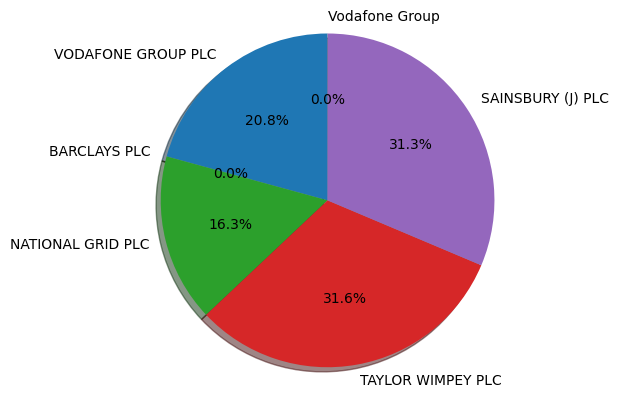

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

labels = []
values = []
for item in valuation.data:
    labels.append(item["Instrument/default/Name"])
    values.append(item["Proportion(Valuation/PvInReportCcy)"] * 100)

fig1, ax1 = plt.subplots()
ax1.pie(values, labels=labels, autopct="%1.1f%%", shadow=True, startangle=90)
ax1.axis("equal")

plt.show()